# Week 6: Fine-tuning ResNet

### 0. Import the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from tqdm import tqdm
from torchvision import models
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import cv2

### 1. Data loading and preprocessing

#### 1.1 Transformation for training dataset

Here, we create a series of transformations for all images in the following sequence:
- Converting the images to grayscale with 3 identical channels (to match the expected input shape for ResNet)
- Resizing the images to 256 x 256 pixels
- Cropping the resized images to 224 x 224 pixels from the center point
- Convert the PIL (Pillow) image to a PyTorch tensor
- Normalize the tensor with each channel to the respective mean and standard deviation. The specific mean and standard deviation values are calculated from the ImageNet dataset, which ResNet was originally trained on.

In [ ]:
train_transforms = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

#### 1.2 Load and split training dataset

We first load the training dataset from the directory. Note: The data is already split into training and testing sets, but we only need to load the training set. Ensure that the root directory of the dataset is `mri_dataset`.

While loading the dataset, we also add the transformations declared earlier.

Next, we split the loaded data into training and validation sets with an 80-20 split. The validation set is used to evaluate the model during training.

In [ ]:
# TODO: Load full dataset and split it into training and validation samples with a random split
import kagglehub
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:00<00:00, 166MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [ ]:
full_dataset = ImageFolder(path + "/Combined Dataset/train", transform=train_transforms)

train_len = int(0.8 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_ds, val_ds = random_split(full_dataset, [train_len, val_len])
print(f"Train: {len(train_ds)} | Validation: {len(val_ds)}")

Train: 8192 | Validation: 2048


In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

### 2. ResNet fine-tuning

#### 2.1 Set default weights for the pre-trained ResNet 50 model.

As mentioned previously, this model was trained on the ImageNet dataset. We will use the weights from this pre-trained model and adjust them to work with our dataset. We are modifying the last 2 layers (layer3 and layer4) of the model along with the final classifier to have 4 output classes, as opposed to the original 1000.

In [ ]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features  # this is 2048 for ResNet50
model.fc = nn.Linear(num_ftrs, 4)  # for 4 output classes

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Use the device's GPU if available.

In [ ]:
# Note: If you have a CUDA GPU, change "mps" to "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

#### 2.2 Declare loss function, optimizer, and scheduler

Here, we are using the Cross Entropy Loss function, Adam optimizer, and Learning Rate Scheduler to train the model.

- The Cross Entropy Loss function is the best option for our purpuses in fine-tuning the ResNet model, as it expects a softmax output, which the ResNet model outputs.
- The Adam optimizer is a good option for fine-tuning purposes and for generalization, which is an important factor for our use-case with medical data. Here, we adjust the learning rates for different layers of the model, increasing as we move forward in the model. This is because the earlier layers pick up higher-level features, while the later layers pick up finer features. Thus, having a lower learning rate for the begining layers helps the model generalize, while a higher learning rate for the later layers helps the model better learn more fine-grained features.
- The Learning Rate Scheduler is used to dynamically adjust the learning rate of the optimizer during training, which can help prevent overfitting and improve the model's generalization ability.

Before we declare the loss, optimizer, and scheduler, however, we need to balance the class weights due to the significant class imbalance in our dataset. For instance, since the number of images in the 'No impairment' class is significantly higher than the number of images in the 'Moderate impairment' class, we need to assign a higher weight to the latter class to penalize errors in the 'Moderate impairment' class more. This leads the model away from just predicting the 'No impariment' class more often just to score a higher accuracy, and to a more balanced model overall.

In [ ]:
y_train = []
for _, labels in train_dl:
    y_train.extend(labels.numpy())
y_train = np.array(y_train)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))

optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-5},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),     "lr": 1e-3}
])
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
device

device(type='cuda')

#### 2.3 Fine-tuning ResNet

We'll be using 15 epochs for fine-tuning. In each epoch, if the validation accuracy improves from the previous epoch, we'll save the new model weights.

As always, we begin with the training part of the loop; moving all the inputs to the GPU (if present), zeroing the optimizer's gradients, calculating the loss, and updating the weights through backpropagation. This is not so different from training traditional CNNs.

Moving to the validation phase of each epoch, we set the model to evaluation mode, and we calculate the validation loss and accuracy. This is again similar to training traditional CNNs.

In [ ]:
best_val_acc = 0.0
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    # --- Train Phase ---
    model.train()
    running_loss = running_corrects = 0

    for inputs, labels in tqdm(train_dl, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dl.dataset)
    epoch_acc = running_corrects / len(train_dl.dataset)
    print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_loss = val_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_dl, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (preds == labels).sum().item()

    val_loss = val_loss / len(val_dl.dataset)
    val_acc = val_corrects / len(val_dl.dataset)
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Step LR
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet_mri.pth")
        print("→ Saved best model")

print("Training complete. Best Validation Accuracy:", best_val_acc)

Epoch 1/15
----------


Training: 100%|██████████| 256/256 [00:51<00:00,  4.98it/s]


Train Loss: 0.5314, Acc: 0.7603


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.78it/s]


Val Loss: 0.3617, Acc: 0.8467
→ Saved best model
Epoch 2/15
----------


Training: 100%|██████████| 256/256 [00:51<00:00,  4.94it/s]


Train Loss: 0.1374, Acc: 0.9504


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.06it/s]


Val Loss: 0.2948, Acc: 0.8750
→ Saved best model
Epoch 3/15
----------


Training: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s]


Train Loss: 0.0268, Acc: 0.9926


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.10it/s]


Val Loss: 0.3165, Acc: 0.8828
→ Saved best model
Epoch 4/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.77it/s]


Train Loss: 0.0155, Acc: 0.9958


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.25it/s]


Val Loss: 0.3968, Acc: 0.8896
→ Saved best model
Epoch 5/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.76it/s]


Train Loss: 0.0112, Acc: 0.9962


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.12it/s]


Val Loss: 0.3557, Acc: 0.9023
→ Saved best model
Epoch 6/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.76it/s]


Train Loss: 0.0119, Acc: 0.9963


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.31it/s]


Val Loss: 0.4154, Acc: 0.8892
Epoch 7/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.77it/s]


Train Loss: 0.0141, Acc: 0.9951


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.64it/s]


Val Loss: 0.3683, Acc: 0.8945
Epoch 8/15
----------


Training: 100%|██████████| 256/256 [00:54<00:00,  4.73it/s]


Train Loss: 0.0082, Acc: 0.9972


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.62it/s]


Val Loss: 0.3303, Acc: 0.9058
→ Saved best model
Epoch 9/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.78it/s]


Train Loss: 0.0024, Acc: 0.9999


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.81it/s]


Val Loss: 0.3261, Acc: 0.9067
→ Saved best model
Epoch 10/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.76it/s]


Train Loss: 0.0017, Acc: 0.9996


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.11it/s]


Val Loss: 0.3311, Acc: 0.9038
Epoch 11/15
----------


Training: 100%|██████████| 256/256 [00:54<00:00,  4.72it/s]


Train Loss: 0.0016, Acc: 0.9998


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.02it/s]


Val Loss: 0.3384, Acc: 0.9087
→ Saved best model
Epoch 12/15
----------


Training: 100%|██████████| 256/256 [00:54<00:00,  4.74it/s]


Train Loss: 0.0010, Acc: 0.9999


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.20it/s]


Val Loss: 0.3470, Acc: 0.9072
Epoch 13/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.74it/s]


Train Loss: 0.0012, Acc: 0.9999


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.11it/s]


Val Loss: 0.3410, Acc: 0.9072
Epoch 14/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.76it/s]


Train Loss: 0.0005, Acc: 1.0000


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.60it/s]


Val Loss: 0.3415, Acc: 0.9106
→ Saved best model
Epoch 15/15
----------


Training: 100%|██████████| 256/256 [00:53<00:00,  4.75it/s]


Train Loss: 0.0006, Acc: 1.0000


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.32it/s]

Val Loss: 0.3531, Acc: 0.9072
Training complete. Best Validation Accuracy: 0.91064453125


In [ ]:
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use CUDA if you are not on Apple Silicon

# Load the best weights
model.load_state_dict(torch.load("best_resnet_mri.pth", map_location="cpu"))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3. Testing

#### 3.1 Data loading and pre-processing

We'll begin by declaring another sequence of pre-processing modifications for the testing data. This is identical to the set of pre-processing modifications we used for the training data.

Similar to the training data, we'll load the dataset and loader.

In [ ]:
preprocess = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

dataset = ImageFolder(path + "/Combined Dataset/test", transform=preprocess)
loader = DataLoader(dataset, batch_size=16, shuffle=False)

#### 3.2 Generate predictions

As always, we'll walk through the inputs and labels in the test dataset and append the predictions to the output array called `all_preds`. To be able to evaluate the model's performance, we'll also append the actual labels to another array caled `all_labels`.

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#### 3.3 Visualizing Model Performance

As with any classification model, we can use the confusion matrix to visualize the performance.

It's interesting to note how the model performs on the test set: it's incorrect predictions often do not seem to be too far from the actual values. For instance, for the Mild Impairment label, most of the incorrect predictions are classified as Very Mild Impairment. This makes sense because the labels are on a scale of the severity of impairment.

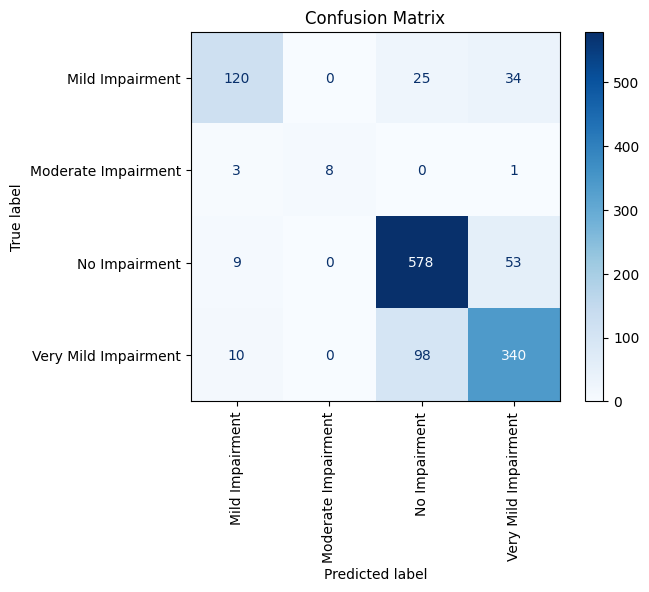

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.85      0.67      0.75       179
 Moderate Impairment       1.00      0.67      0.80        12
       No Impairment       0.82      0.90      0.86       640
Very Mild Impairment       0.79      0.76      0.78       448

            accuracy                           0.82      1279
           macro avg       0.87      0.75      0.80      1279
        weighted avg       0.82      0.82      0.82      1279



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

print(f"Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

### 4. Feature visualization (Bonus)

Here, we will take a look at the features learned by the 4 layers of ResNet. As a reminder, here's a diagram of the ResNet architecture:

<img src="resnet50_architecture.png" width="50%" height="50%"/>

This process is exactly the same as what we did last week. The only difference is that the last convolutional layer in ResNet 50 is accessed by ```model.layer4[-1].conv3```.

In [ ]:
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output.detach()

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

In [ ]:
target_layer = model.layer4[-1].conv3  # for ResNet50/101/152
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [ ]:
img = Image.open(path + "/Combined Dataset/test/Mild Impairment/1 (2).jpg").convert('RGB')

input_tensor = preprocess(img).unsqueeze(0).to(device)

input_tensor.requires_grad = True

print("Input image shape:", input_tensor.shape)

Input image shape: torch.Size([1, 3, 224, 224])


In [ ]:
output = model(input_tensor)
class_idx = output.argmax().item()  # or specify class manually

In [ ]:
model.zero_grad()
output[0, class_idx].backward()

In [ ]:
# Compute weights
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # shape: [1, C, 1, 1]

# Weighted combination of activations
gradcam = torch.sum(weights * activations, dim=1).squeeze()  # shape: [H, W]

# ReLU and normalize
gradcam = nn.functional.relu(gradcam)
gradcam = gradcam - gradcam.min()
gradcam = gradcam / gradcam.max()
gradcam = gradcam.cpu().numpy()

In [ ]:
# Resize heatmap to original image size
heatmap = cv2.resize(gradcam, (img.width, img.height))
heatmap = np.uint8(255 * heatmap)  # scale to 0-255 for colormap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply colormap

In [ ]:
img_np = np.array(img)  # PIL -> NumPy (H, W, 3), RGB format
if img_np.shape[-1] == 4:
    img_np = img_np[..., :3]  # remove alpha if present

# Convert RGB to BGR for OpenCV overlay
img_np_bgr = img_np[..., ::-1]

# Overlay heatmap on top of the image
overlay = cv2.addWeighted(img_np_bgr, 0.6, heatmap, 0.4, 0)

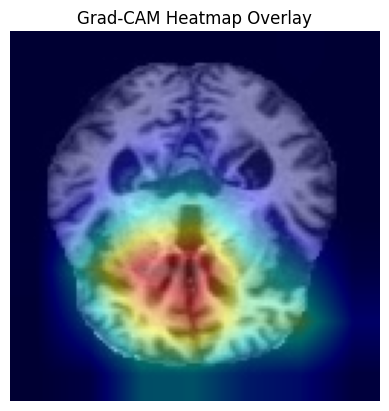

In [ ]:
# Convert back to RGB for matplotlib
overlay_rgb = overlay[..., ::-1]

plt.imshow(overlay_rgb)
plt.axis('off')
plt.title('Grad-CAM Heatmap Overlay')
plt.show()